In [1]:
import torch

path = "cora/"
cites = path + "cora.cites"
content = path + "cora.content"

# 索引字典，将原本的论文id转换到从0开始编码
index_dict = dict()
# 标签字典，将字符串标签转化为数值
label_to_index = dict()

features = []
labels = []
edge_index = []

with open(content,"r") as f:
    nodes = f.readlines()
    for node in nodes:
        node_info = node.split()
        index_dict[int(node_info[0])] = len(index_dict)
        features.append([int(i) for i in node_info[1:-1]])
        
        label_str = node_info[-1]
        if(label_str not in label_to_index.keys()):
            label_to_index[label_str] = len(label_to_index)
        labels.append(label_to_index[label_str])

with open(cites,"r") as f:
    edges = f.readlines()
    for edge in edges:
        start, end = edge.split()
        # 训练时将边视为无向的，但原本的边是有向的，因此需要正反添加两次
        edge_index.append([index_dict[int(start)],index_dict[int(end)]])
        edge_index.append([index_dict[int(end)],index_dict[int(start)]])

# 为每个节点增加自环，但后续GCN层默认会添加自环，跳过即可
# for i in range(2708):
#     edge_index.append([i,i])
  
# 转换为Tensor
labels = torch.LongTensor(labels)
features = torch.FloatTensor(features)
# 行归一化
# features = torch.nn.functional.normalize(features, p=1, dim=1)
edge_index =  torch.LongTensor(edge_index)



In [2]:
class GCNNet(torch.nn.Module):
    def __init__(self, num_feature, num_label):
        super(GCNNet,self).__init__()
        self.GCN1 = GCNConv(num_feature, 16)
        self.GCN2 = GCNConv(16, num_label)  
        self.dropout = torch.nn.Dropout(p=0.5)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.GCN1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.GCN2(x, edge_index)
        
        return F.log_softmax(x, dim=1)


In [3]:
class GATNet(torch.nn.Module):
    def __init__(self, num_feature, num_label):
        super(GATNet,self).__init__()
        self.GAT1 = GATConv(num_feature,6, heads = 6, concat = True, dropout = 0.01)
#         self.GAT1 = GATConv(num_feature, 8, heads = 8, concat = True, dropout = 0.6)
        self.GAT2 = GATConv(6*6, 4,heads=8, dropout = 0.01)   #8*8是上面的8*头数
        self.GAT3 = GATConv(32,num_label,)
         
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.GAT1(x, edge_index)
        x = F.relu(x)
        # x = F.leaky_relu(x)
        x = self.GAT2(x, edge_index)
        
        x = F.leaky_relu(x)
        x = self.GAT3(x,edge_index)

        return F.log_softmax(x, dim=1)


In [4]:
import numpy as np
# seed = 1234
seed = 5678
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  # Numpy module.
# random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


In [5]:
from torch_geometric.data import Data

In [6]:
mask = torch.randperm(len(index_dict))
train_mask = mask[:140]
val_mask = mask[140:640]
test_mask = mask[640:2708]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cora = Data(x = features, edge_index = edge_index.t().contiguous(), y = labels).to(device)


In [7]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,GATConv,SAGEConv
from torch_geometric.datasets import Planetoid

In [8]:
model = GATNet(features.shape[1], len(label_to_index)).to(device)
# model = GCNNet(features.shape[1], len(label_to_index)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(200):
    optimizer.zero_grad()
    out = model(cora)
    loss = F.nll_loss(out[train_mask], cora.y[train_mask])
    print('epoch: %d loss: %.4f' %(epoch, loss))
    loss.backward()
    optimizer.step()
    
    if((epoch + 1)% 10 == 0):
        model.eval()
        _, pred = model(cora).max(dim=1)
        correct = int(pred[test_mask].eq(cora.y[test_mask]).sum().item())
        acc = correct / len(test_mask)
        print('Accuracy: {:.4f}'.format(acc))
        model.train()


epoch: 0 loss: 1.9467
epoch: 1 loss: 1.8016
epoch: 2 loss: 1.6163
epoch: 3 loss: 1.4077
epoch: 4 loss: 1.2067
epoch: 5 loss: 1.0091
epoch: 6 loss: 0.8098
epoch: 7 loss: 0.6256
epoch: 8 loss: 0.4705
epoch: 9 loss: 0.3504
Accuracy: 0.7863
epoch: 10 loss: 0.2516
epoch: 11 loss: 0.1765
epoch: 12 loss: 0.1226
epoch: 13 loss: 0.0862
epoch: 14 loss: 0.0620
epoch: 15 loss: 0.0458
epoch: 16 loss: 0.0346
epoch: 17 loss: 0.0278
epoch: 18 loss: 0.0237
epoch: 19 loss: 0.0206
Accuracy: 0.7897
epoch: 20 loss: 0.0184
epoch: 21 loss: 0.0165
epoch: 22 loss: 0.0153
epoch: 23 loss: 0.0149
epoch: 24 loss: 0.0139
epoch: 25 loss: 0.0137
epoch: 26 loss: 0.0130
epoch: 27 loss: 0.0131
epoch: 28 loss: 0.0129
epoch: 29 loss: 0.0128
Accuracy: 0.7790
epoch: 30 loss: 0.0126
epoch: 31 loss: 0.0122
epoch: 32 loss: 0.0117
epoch: 33 loss: 0.0118
epoch: 34 loss: 0.0107
epoch: 35 loss: 0.0113
epoch: 36 loss: 0.0118
epoch: 37 loss: 0.0132
epoch: 38 loss: 0.0094
epoch: 39 loss: 0.0096
Accuracy: 0.7868
epoch: 40 loss: 0.0092

# PR

In [9]:


A  = pred[test_mask].numpy()
type(A)
B = cora.y[test_mask].numpy()

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

print(classification_report(y_true = A,y_pred = B,digits=4))

print(f1_score(y_true=A,y_pred=B, average="micro"))

print(f1_score(y_true=A,y_pred=B,average="macro"))


              precision    recall  f1-score   support

           0     0.8861    0.8104    0.8466       691
           1     0.3723    0.8947    0.5258        57
           2     0.7751    0.8344    0.8037       157
           3     0.6688    0.9163    0.7732       227
           4     0.8113    0.6214    0.7038       346
           5     0.8903    0.8820    0.8861       322
           6     0.7532    0.6604    0.7038       268

    accuracy                         0.7863      2068
   macro avg     0.7367    0.8028    0.7490      2068
weighted avg     0.8106    0.7863    0.7902      2068

0.786266924564797
0.748986618023314


# 画图

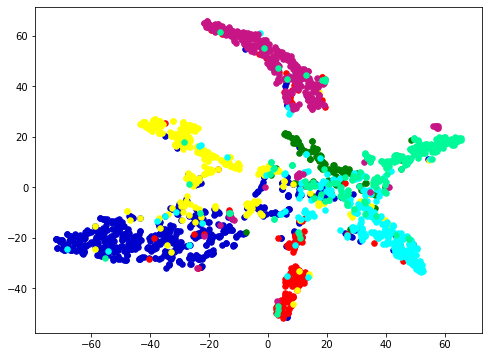

In [10]:
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

import matplotlib


ts = TSNE(n_components=2)
ts.fit_transform(out[test_mask].to('cpu').detach().numpy())

x = ts.embedding_
y = cora.y[test_mask].to('cpu').detach().numpy()

xi = []
for i in range(7):
    xi.append(x[np.where(y==i)])

colors = ['mediumblue','green','red','yellow','cyan','mediumvioletred','mediumspringgreen']
plt.figure(figsize=(8, 6))
# plt.title('GAT_3_layer')
for i in range(7):
    plt.scatter(xi[i][:,0],xi[i][:,1],s=30,color=colors[i],marker='o',alpha=1)
plt.savefig('GAT_3_layer_(5678).png',dpi=300)

In [11]:
1981+1208+819+768+1156+884+1153


7969